# CSM148 Project 2 - Binary Classification Comparative Methods

For this project we're going to attempt a binary classification of a dataset using multiple methods and compare results. 

Our goals for this project will be to introduce you to several of the most common classification techniques, how to perform them and tweek parameters to optimize outcomes, how to produce and interpret results, and compare performance. You will be asked to analyze your findings and provide explanations for observed performance. 

Specifically you will be asked to classify whether a <b>patient is suffering from heart disease</b> based on a host of potential medical factors.

<b><u>DEFINITIONS</b></u>


<b> Binary Classification:</b>
In this case a complex dataset has an added 'target' label with one of two options. Your learning algorithm will try to assign one of these labels to the data.

<b> Supervised Learning:</b>
This data is fully supervised, which means it's been fully labeled and we can trust the veracity of the labeling.

## Background: The Dataset 

For this exercise we will be using a subset of the UCI Heart Disease dataset, leveraging the fourteen most commonly used attributes. All identifying information about the patient has been scrubbed. 

The dataset includes 14 columns. The information provided by each column is as follows:
<ul>
    <li><b>age:</b> Age in years</li>
    <li><b>sex:</b> (1 = male; 0 = female)</li>
    <li><b>cp:</b> Chest pain type (0 = asymptomatic; 1 = atypical angina; 2 = non-anginal pain; 3 = typical angina)</li>
    <li><b>trestbps:</b> Resting blood pressure (in mm Hg on admission to the hospital)</li>
    <li><b>cholserum:</b> Cholestoral in mg/dl</li>
    <li><b>fbs</b> Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)</li>
    <li><b>restecg:</b> Resting electrocardiographic results (0= showing probable or definite left ventricular hypertrophy by Estes' criteria; 1 = normal; 2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))</li>
    <li><b>thalach:</b> Maximum heart rate achieved</li>
    <li><b>exang:</b> Exercise induced angina (1 = yes; 0 = no)</li>
    <li><b>oldpeakST:</b> Depression induced by exercise relative to rest</li>
    <li><b>slope:</b> The slope of the peak exercise ST segment (0 = downsloping; 1 = flat; 2 = upsloping)</li>
    <li><b>ca:</b> Number of major vessels (0-4) colored by flourosopy</li>
    <li><b>thal:</b> 1 = normal; 2 = fixed defect; 3 = reversable defect</li>
    <li><b><u>Sick:</u></b> Indicates the presence of Heart disease (True = Disease; False = No disease)</li>
</ul>
    


## Loading Essentials and Helper Functions 

In [1]:
#Here are a set of libraries we imported to complete this assignment. 
#Feel free to use these or equivalent libraries for your implementation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 
import os
import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc
from sklearn.model_selection import KFold


from matplotlib import pyplot
import itertools

%matplotlib inline

import random 
  
random.seed(42) 

In [2]:
# Helper function allowing you to export a graph
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
# Helper function that allows you to draw nicely formatted confusion matrices
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

## Part 1. Load the Data and Analyze

Let's first load our dataset so we'll be able to work with it. (correct the relative path if your notebook is in a different directory than the csv file.)

In [4]:
heartdisease = pd.read_csv("./heartdisease.csv")

### Now that our data is loaded, let's take a closer look at the dataset we're working with. Use the head method,  the describe method, and the info method to display some of the rows so we can visualize the types of data fields we'll be working with.

In [7]:
print(heartdisease.head())
print(heartdisease.describe())
print(heartdisease.info())

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   

   ca  thal   sick  
0   0     1  False  
1   0     2  False  
2   0     2  False  
3   0     2  False  
4   0     2  False  
              age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  126.0000

### Sometimes data will be stored in different formats (e.g., string, date, boolean), but many learning methods work strictly on numeric inputs. Call the info method to determine the datafield type for each column. Are there any that are problemmatic and why?

All the columns in our dataframe are either int or float; however, our target variable 'sick' is a boolean and will likely need to be modified.

### Determine if we're dealing with any null values. If so, report on which columns? 

In [8]:
heartdisease.isnull().values.any()

False

We are not dealing with any null values. This makes sense as I am sure the UCI dataset is very robust.

### Before we begin our analysis we need to fix the field(s) that will be problematic. Specifically convert our boolean sick variable into a binary numeric target variable (values of either '0' or '1'), and then drop the original sick datafield from the dataframe. (hint: try label encoder or .astype()

In [9]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(heartdisease['sick'])
heartdisease['sick'] = le.transform(heartdisease['sick'])
heartdisease['sick']

0      0
1      0
2      0
3      0
4      0
      ..
298    1
299    1
300    1
301    1
302    1
Name: sick, Length: 303, dtype: int64

### Now that we have a feel for the data-types for each of the variables, plot histograms of each field and attempt to ascertain how each variable performs (is it a binary, or limited selection, or does it follow a gradient? 

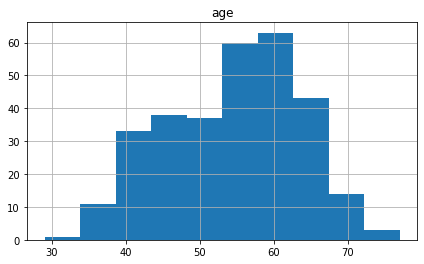

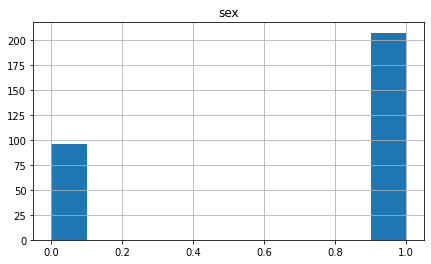

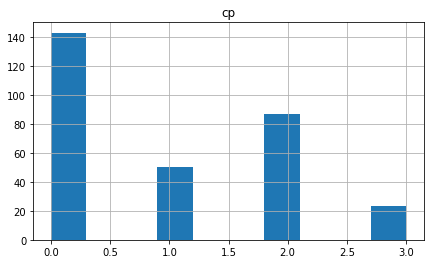

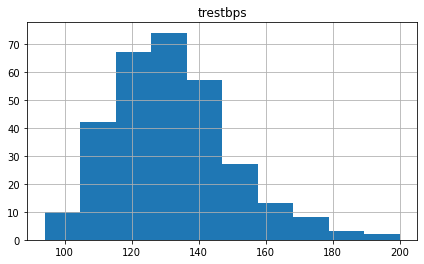

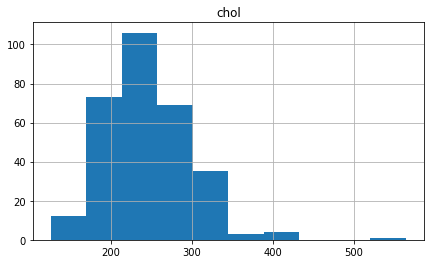

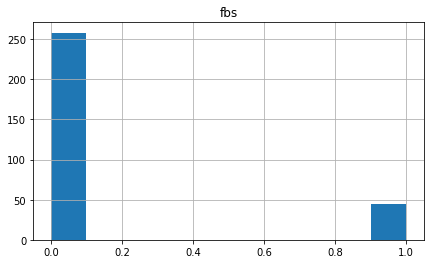

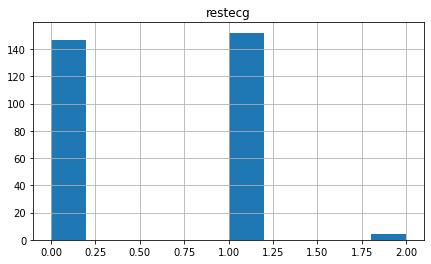

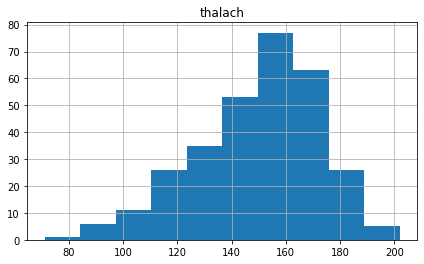

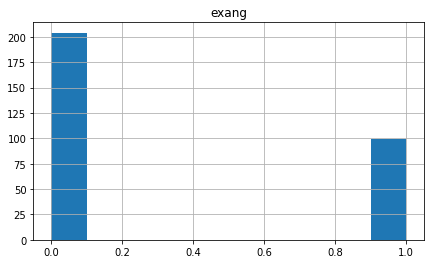

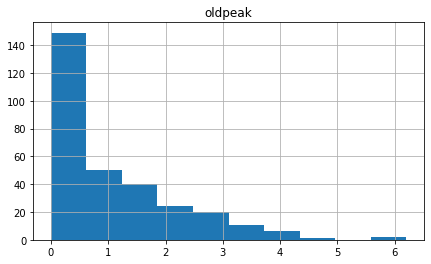

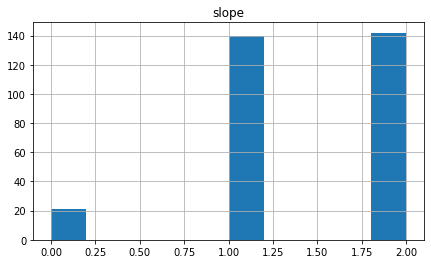

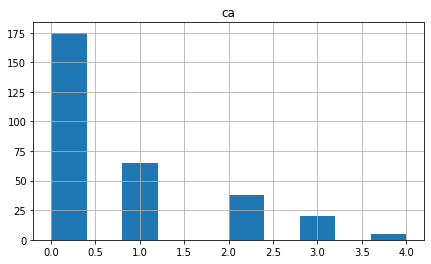

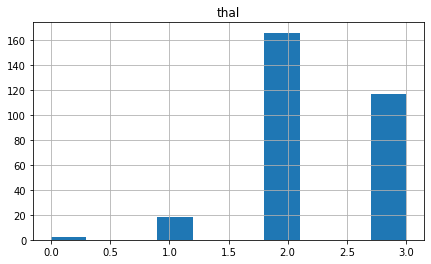

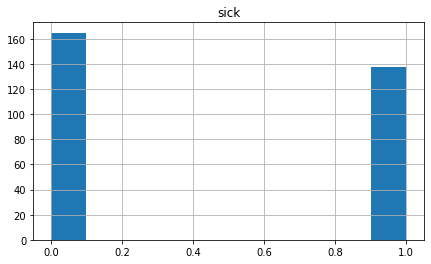

In [132]:
for c in heartdisease:
    heartdisease.hist(column=c, bins=10, figsize=(7,4))
    plt.show()

### We also want to make sure we are dealing with a balanced dataset. In this case, we want to confirm whether or not we have an equitable number of  sick and healthy individuals to ensure that our classifier will have a sufficiently balanced dataset to adequately classify the two. Plot a histogram specifically of the sick target, and conduct a count of the number of sick and healthy individuals and report on the results: 

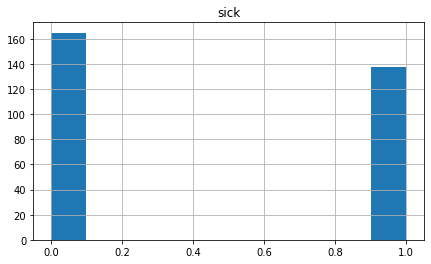

sick
0    165
1    138
Name: sick, dtype: int64

In [11]:
heartdisease.hist(column='sick', bins=10, figsize=(7,4))
plt.show()
heartdisease.groupby('sick')['sick'].count()

It appears that there is an equitable distribution of sick and healthy individuals. The ratio between them is about 1.2:1 which can be described as nicely balanced and thus will be good for our model to learn on.

### Balanced datasets are important to ensure that classifiers train adequately and don't overfit, however arbitrary balancing of a dataset might introduce its own issues. Discuss some of the problems that might arise by artificially balancing a dataset.

Artificially balancing a dataset is problematic because you want your data to be as close to the real world as possible. You don't want to artificially add any biases into your data by implying to your model that one category is more (or less) common than it actually is.

### Now that we have our dataframe prepared let's start analyzing our data. For this next question let's look at the correlations of our variables to our target value. First, map out the correlations between the values, and then discuss the relationships you observe. Do some research on the variables to understand why they may relate to the observed corellations. Intuitively, why do you think some variables correlate more highly than others (hint: one possible approach you can use the sns heatmap function to map the corr() method)?

<AxesSubplot:>

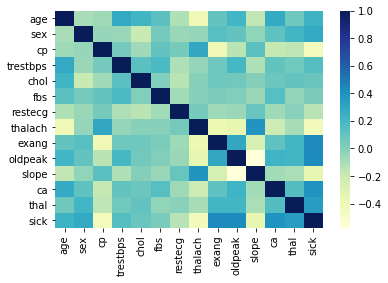

In [12]:
sns.heatmap(heartdisease.corr(), cmap="YlGnBu")

We can see that exang (exercise induced angina), oldpeak (depression induced by exercise relative to rest), ca (number of major vessels colored by flourosopy), and thal all have a strong positive correlation with being sick. age, sex, and trestbps (resting blood pressure) also have a positive correlation with being sick, although not as strong. This all seems to make sense as this variables to seem more strongly related to being sick. The ones that are strongly correlated seem to have a direct connection to the heart and its health. Age, sex, and resting blood pressure also intuitively seem connected to having a healthy heart (although sex less so). Additionally, cp (chest pain type) and slope (slope of the peark exercise ST segment) have a somewhat strong negative correlation to being sick. This also make sense intuitively because those variables seem closely connected to the heart.

## Part 2. Prepare the Data and run a KNN Model

Before running our various learning methods, we need to do some additional prep to finalize our data. Specifically you'll have to cut the classification target from the data that will be used to classify, and then you'll have to divide the dataset into training and testing cohorts.

Specifically, we're going to ask you to prepare 2 batches of data: 1. Will simply be the raw numeric data that hasn't gone through any additional pre-processing. The other, will be data that you pipeline using your own selected methods. We will then feed both of these datasets into a classifier to showcase just how important this step can be!

### Save the label column as a separate array and then drop it from the dataframe. 

In [13]:
heartdisease_labels = heartdisease["sick"].copy()
heartdisease_features = heartdisease.drop("sick", axis=1)

### First Create your 'Raw' unprocessed training data by dividing your dataframe into training and testing cohorts, with your training cohort consisting of 80% of your total dataframe (hint: use the train_test_split method) Output the resulting shapes of your training and testing samples to confirm that your split was successful.

In [14]:
train, test, target, target_test = train_test_split(heartdisease_features, heartdisease_labels, test_size=0.2, random_state=0)
print(train.shape)
print(test.shape)

(242, 13)
(61, 13)


### In lecture we learned about K-Nearest Neighbor. One thing we noted was because KNN's rely on Euclidean distance, they are highly sensitive to the relative magnitude of different features. Let's see that in action! Implement a K-Nearest Neighbor algorithm on our data and report the results. For this initial implementation simply use the default settings. Refer to the [KNN Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) for details on implementation. Report on the accuracy of the resulting model.

In [15]:
# k-Nearest Neighbors algorithm
knn = KNeighborsClassifier()
knn.fit(train, target)

KNeighborsClassifier()

In [16]:
# Report on model Accuracy
knn.score(test, target_test)

0.639344262295082

### Now implement a pipeline of your choice. You can opt to handle categoricals however you wish, however please scale your numeric features using standard scaler

### Pipeline:

In [112]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing

heartdisease = pd.read_csv("./heartdisease.csv")

le = preprocessing.LabelEncoder()
le.fit(heartdisease['sick'])
heartdisease['sick'] = le.transform(heartdisease['sick'])
heartdisease_labels = heartdisease["sick"].copy()
heartdisease_features = heartdisease.drop("sick", axis=1)

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

categorical_features = ['sex', 'fbs', 'restecg', 'exang', 'thal']
numerical_features = list(heartdisease_features.drop(categorical_features, axis=1))

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_features),
        ("cat", OneHotEncoder(), categorical_features),
    ])

heartdisease_prepared = full_pipeline.fit_transform(heartdisease_features)

### Now split your pipelined data into an 80/20 split and again run the same KNN, and report out on it's accuracy. Discuss the implications of the different results you are obtaining.

In [113]:
#train test split
train, test, target, target_test = train_test_split(heartdisease_prepared, heartdisease_labels, test_size=0.2, random_state=0)

# k-Nearest Neighbors algorithm
knn = KNeighborsClassifier()
knn.fit(train, target)

KNeighborsClassifier()

In [114]:
# Accuracy
knn.score(test, target_test)

0.8688524590163934

The KNN accuracy was much higher when using the pipelined data as opposed to using the raw data. This makes it clear that pipelining and scaling the numeric features actually has a large effect on the accuracy of our model, implying that before the data was not properly scaled which was hurting our model's accuracy. 

### Parameter Optimization.  As we saw in lecture, the KNN Algorithm includes an n_neighbors attribute that specifies how many neighbors to use when developing the cluster. (The default value is 5, which is what your previous model used.) Lets now try n values of: 1, 2, 3, 5, 7, 9, 10, 20, and 50. Run your model for each value and report the accuracy for each. (HINT leverage python's ability to loop to run through the array and generate results without needing to manually code each iteration).

In [115]:
for n in [1, 2, 3, 5, 7, 9, 10, 20, 50]:
    knn = KNeighborsClassifier(n_neighbors = n)
    knn.fit(train, target)
    print(f"N = {n}, Accuracy = {knn.score(test, target_test)}")

N = 1, Accuracy = 0.8032786885245902
N = 2, Accuracy = 0.7704918032786885
N = 3, Accuracy = 0.8688524590163934
N = 5, Accuracy = 0.8688524590163934
N = 7, Accuracy = 0.8688524590163934
N = 9, Accuracy = 0.8360655737704918
N = 10, Accuracy = 0.819672131147541
N = 20, Accuracy = 0.8524590163934426
N = 50, Accuracy = 0.819672131147541


## Part 3. Additional Learning Methods 

So we have a model that seems to work well. But let's see if we can do better! To do so we'll employ multiple learning methods and compare result.

### Linear Decision Boundary Methods 

### Logistic Regression

Let's now try another classifier, we introduced in lecture, one that's well known for handling linear models: Logistic Regression. Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable.

### Implement a Logistical Regression Classifier. Review the [Logistical Regression Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for how to implement the model. 

In [116]:
# Logistic Regression
lg = LogisticRegression(random_state=0).fit(train, target)

### This time report four metrics: Accuracy, Precision, Recall, and F1 Score, and plot a Confusion Matrix. 

Accuracy: 0.8688524590163934
Precision: 0.88
Recall: 0.8148148148148148
F1: 0.8461538461538461


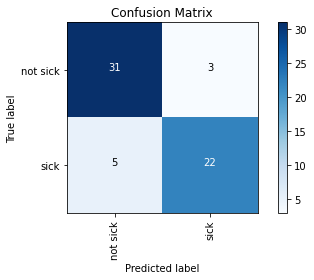

In [117]:
print(f"Accuracy: {lg.score(test, target_test)}")

from sklearn.metrics import precision_recall_fscore_support
results = lg.predict(test)
precision, recall, f1, x = precision_recall_fscore_support(target_test, results, average='binary')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

draw_confusion_matrix(target_test, results, ['not sick', 'sick'])

### Discuss what each measure is reporting, why they are different, and why are each of these measures is significant. Explore why we might choose to evaluate the performance of differing models differently based on these factors. Try to give some specific examples of scenarios in which you might value one of these measures over the others.

Accuracy is reporting the number of correct classifications divided by the total number of classifications. Accuracy is a basic metric for given some baseline for your model. Overall, the more accurate your model is, the better; after all, we are building this model to try and make accurate predictions. 
    Precision reports the number of correct positive guesses divided by the number of predicted positives. This is a very important metric and relates directly to false positives. We want our precision to be very high when we do not want false positives. This model could be an example of such a case, and there are others. False positives can be very harmful (e.g. if you predict that someone has cancer and put them on chemo when in reality they do not have cancer) and this in some cases one might really care about this metric and try to improve it. 
    Recall measures the number of correct positive prediction divided by the true number of observations in the positive class. This is an important metric and relates to the number of false negatives that your model is outputting. This has a lot of applications in certain models as well, particularly when you want to avoid false negatives and thus have a high recall. An example of this is also our model. We don't want to be telling people who are actually sick that they are not sick, and this is perhaps the most detrimental mistake that our model could make, and there are other models and use cases where this same fact is true.
    Lastly, the F1 score is the weighted average of precision and recall and therefore takes both false negatives and positives into account. This is a great metric when you want to measure the general performance of your model in minimizing both error types. A good use case of this is, again, something like our model. As I previously stated, both false negatives and false positives are very bad in our model (and a lot worse in something like predicting cancer) and thus we want to avoid both of these, so using the F1 score to get a balanced average between them can be really useful.

### Graph the resulting ROC curve of the model

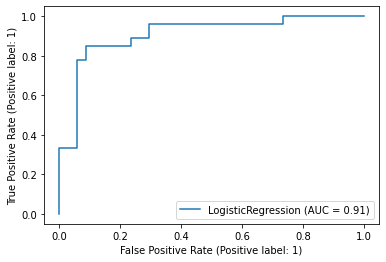

In [118]:
metrics.plot_roc_curve(lg, test, target_test)
plt.show()

### Describe what an ROC curve is and what the results of this graph seem to be indicating

An ROC curve is a receiver operating characteristic curve. The curve is created by plotting thetrue positive rate against the false positive rate at various threshold settings. The area under the curve is the usefulness of the test, meaning that a model with AUC = 1 has the best separability. The ROC curve that was just generated indicates that our model is actually fairly good and that there is some good separability. We can see that with a TP rate of around 0.9, we only have a FP rate of about 0.2 which is indication of a strong model.

### Let's tweak a few settings. First let's set your solver to 'sag', your max_iter= 10, and set penalty = 'none' and rerun your model. Report out the same metrics. Let's see how your results change!

/mnt/c/Users/ryanr/OneDrive/Desktop/UCLA/CSM148/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy: 0.8688524590163934
Precision: 0.88
Recall: 0.8148148148148148
F1: 0.8461538461538461


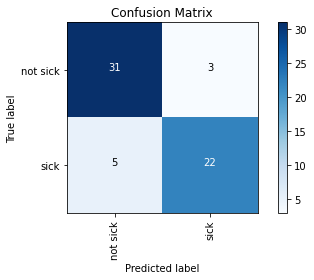

In [119]:
# Logistic Regression
lg_2 = LogisticRegression(random_state=0, solver='sag', max_iter=10, penalty='none').fit(train, target)
print(f"Accuracy: {lg_2.score(test, target_test)}")

results_2 = lg_2.predict(test)
precision_2, recall_2, f1_2, x = precision_recall_fscore_support(target_test, results, average='binary')

print(f"Precision: {precision_2}")
print(f"Recall: {recall_2}")
print(f"F1: {f1_2}")

draw_confusion_matrix(target_test, results_2, ['not sick', 'sick'])

### Did you notice that when you ran the previous model you got the following warning: "ConvergenceWarning: The max_iter was reached which means the coef_ did not converge". Check the documentation and see if you can implement a fix for this problem, and again report your results.

/mnt/c/Users/ryanr/OneDrive/Desktop/UCLA/CSM148/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy: 0.8524590163934426
Precision: 0.875
Recall: 0.7777777777777778
F1: 0.823529411764706


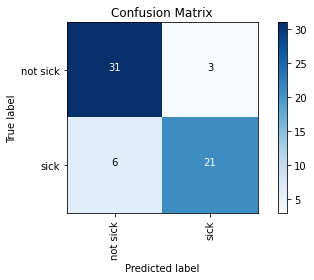

In [120]:
# Logistic Regression
lg_3 = LogisticRegression(random_state=0, solver='sag', max_iter=50, penalty='none').fit(train, target)
print(f"Accuracy: {lg_3.score(test, target_test)}")

results = lg_3.predict(test)
precision, recall, f1, x = precision_recall_fscore_support(target_test, results, average='binary')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

draw_confusion_matrix(target_test, results, ['not sick', 'sick'])

### Explain what you changed, and why do you think, even though you 'fixed' the problem, that you may have harmed the outcome. What other Parameters you set may have impacted this result?

I changed the max_iter parameter because it appears that the coef_ attribute was unable to converge  because the max_iter limit was reached too early, so I increased it which fixed the issue. One possible reason of why increasing max_iter would harm the outcome of the model could be that the model ends up diverging instead of converging. Changing the solver could definitely impact the results and changing the penalty could also impact the results because both of those affect how the model is learning.

### Rerun your logistic classifier, but modify the penalty = 'l1', solver='liblinear' and again report the results.

Accuracy: 0.8688524590163934
Precision: 0.88
Recall: 0.8148148148148148
F1: 0.8461538461538461


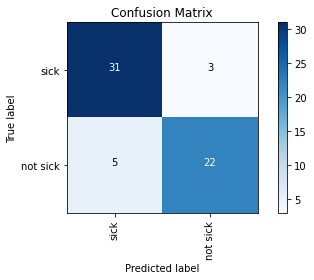

In [121]:
# Logistic Regression
lg_4 = LogisticRegression(random_state=0, solver='liblinear', max_iter=100, penalty='l1').fit(train, target)
print(f"Accuracy: {lg_4.score(test, target_test)}")

results = lg_4.predict(test)
precision, recall, f1, x = precision_recall_fscore_support(target_test, results, average='binary')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

draw_confusion_matrix(target_test, results, ['sick', 'not sick'])

### Explain what what the two solver approaches are, and why the liblinear likely produced the optimal outcome. 

The two solvers are two methods of measuring the loss and optimizing the model. Liblinear is likely to produce a more optimal outcome because, according to the documentation: " ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones." Our dataset is on the much smaller size so it would make sense to use liblinear in this case.

### We also played around with different penalty terms (none, L1 etc.) Describe what the purpose of a penalty term is and how an L1 penalty works.

A penalty term is a normalizatin function used to reduce the complexity of our model in order to minimize overfitting. They essentially work by reducing the coefficient values asociated with certain features as well as reducing the dimensionality of the quadratic terms. L1 penalty is a LASSO penalty, which leverages the absolute sum of the coefficients. L1 penalizes proportional to the increase in value of the coefficients from 0. This tends to force the coefficients to zero out and thus reduce the complexity of the resulting model.

### SVM (Support Vector Machine)

A Support Vector Machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples. In two dimentional space this hyperplane is a line dividing a plane in two parts where in each class lay in either side.

### Implement a Support Vector Machine classifier on your pipelined data. Review the [SVM Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) for how to implement a model. For this implementation you can simply use the default settings, but set probability = True.

In [122]:
# SVM
svm_1 = SVC(probability=True)
svm_1.fit(train, target)

SVC(probability=True)

### Report the accuracy, precision, recall, F1 Score, and confusion matrix and ROC Curve of the resulting model.

Accuracy: 0.8524590163934426
Precision: 0.9090909090909091
Recall: 0.7407407407407407
F1: 0.8163265306122449


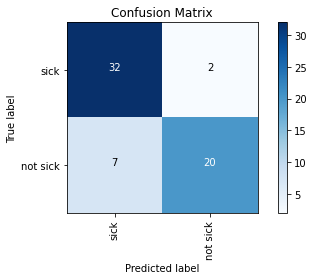

In [123]:
print(f"Accuracy: {svm_1.score(test, target_test)}")

results = svm_1.predict(test)
precision, recall, f1, x = precision_recall_fscore_support(target_test, results, average='binary')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

draw_confusion_matrix(target_test, results, ['sick', 'not sick'])

### Rerun your SVM, but now modify your model parameter kernel to equal 'linear'. Again report your Accuracy, Precision, Recall, F1 scores, and Confusion matrix and plot the new ROC curve.  

In [124]:
# SVM
svm_2 = SVC(probability=True, kernel='linear')
svm_2.fit(train, target)

SVC(kernel='linear', probability=True)

Accuracy: 0.8852459016393442
Precision: 0.9166666666666666
Recall: 0.8148148148148148
F1: 0.8627450980392156


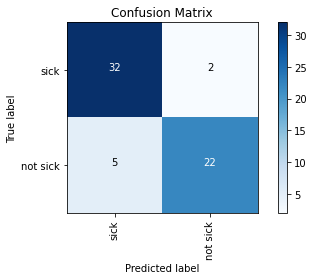

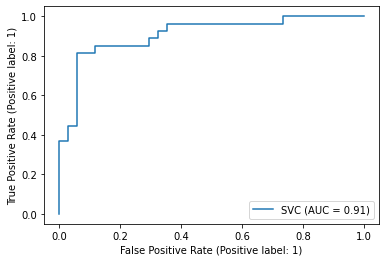

In [125]:
print(f"Accuracy: {svm_2.score(test, target_test)}")

results = svm_2.predict(test)
precision, recall, f1, x = precision_recall_fscore_support(target_test, results, average='binary')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

draw_confusion_matrix(target_test, results, ['sick', 'not sick'])

metrics.plot_roc_curve(svm_2, test, target_test)
plt.show()

### Explain the what the new results you've achieved mean. Read the documentation to understand what you've changed about your model and explain why changing that input parameter might impact the results in the manner you've observed.

We can see that the model achieved better results with the linear kernel type as opposed to the default value RBF which is nonlinear. RBF and linear are two kernel functions that change the approach to the way that the SVM builds its decision boundary. RBF is optimal for non-linear problems whereas linear SVMs are optimal for linear problems. By seeing that the linear kernel made the model overall better, we can conclude that our data likely fits into the latter class, which would be linear. RBF has trouble generalizing and likely overfit the data slightly, whereas the linear model seems the clear better approach.  

### Both logistic regression and linear SVM are trying to classify data points using a linear decision boundary, then what’s the difference between their ways to find this boundary?

While logistic regressions builds a linear boundary to classify data, it is not itself linear. In fact, it is nonlinear. Logistic regression uses a logistic sigmoid function to calculate a probability that a data point is in one class or the other. This probability then goes through an activation function which eventually determines which class this point is in. Coming up with this equation/curve comes from a similar method in determining a linear regression model. 
    SVMs, on the other hand, simply try and create the linear decision boundary itself. They use a multitude of methods to come up with the best linear boundary to classify the data (such as a kernel function or soft margin). Instead of building a log odds probability of the class of a data point and having a whole curve to determine, SVMs simply optimally build the boundary and then determine which side future data points lie in. 

## Baysian (Statistical) Classification

In class we will be learning about Naive Bayes, and statistical classification.

Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable. Bayes’ theorem states the following relationship, given class variable Y  and dependent feature vector X1 through Xn. 

### Please implement a Naive Bayes Classifier on the pipelined data. For this model simply use the default parameters. Report out the number of mislabeled points that result (i.e., both the false positives and false negatives), along with the accuracy, precision, recall, F1 Score and Confusion Matrix. Refer to documentation on implementing a NB Classifier [here](https://scikit-learn.org/stable/modules/naive_bayes.html)

In [126]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(train, target)

GaussianNB()

Accuracy: 0.8032786885245902
Precision: 0.8
Recall: 0.7407407407407407
F1: 0.7692307692307692
Number of mislabeled points out of a total 61 points : 12


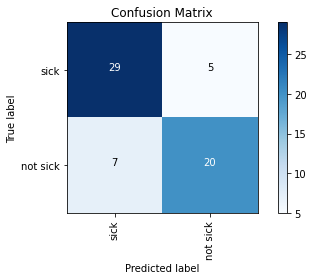

In [127]:
print(f"Accuracy: {gnb.score(test, target_test)}")

results = gnb.predict(test)
precision, recall, f1, x = precision_recall_fscore_support(target_test, results, average='binary')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

print("Number of mislabeled points out of a total %d points : %d"
%(test.shape[0], (target_test != results).sum()))

draw_confusion_matrix(target_test, results, ['sick', 'not sick'])

### Discuss the observed results. What assumptions about our data are we making here and why might those be inacurate?

It seems that the naive bayes model did not perform so well. Naive bayes works under the assumption that there is conditional independence between every pair of featuress given the value of the class variable. This is likely not entirely the case in our datset as our feature variables are very likely dependant on one another which is likely why we are seeing a detioration of the model when using naive bayes. 

## Cross Validation and Model Selection

You've sampled a number of different classification techniques, leveraging clusters, linear classifiers, and Statistical Classifiers, as well as experimented with tweak different parameters to optimize perfiormance. Based on these experiments you should have settled on a particular model that performs most optimally on the chosen dataset. 

Before our work is done though, we want to ensure that our results are not the result of the random sampling of our data we did with the Train-Test-Split. To ensure otherwise we will conduct a K-Fold Cross-Validation of our top two performing models, assess their cumulative performance across folds, and determine the best model for our particular data. 

## Select your top 2 performing models and run a K-Fold Cross Validation on both (use 10 folds). Report your best performing model.

In [128]:
kfold = KFold(n_splits=10, random_state=42, shuffle=True) 

svm_model_kfold = SVC(probability=True, kernel='linear')

svm_results_kfold = cross_val_score(svm_model_kfold, heartdisease_prepared, heartdisease_labels, cv=kfold)

print("SVM Regression Accuracy: %.2f%%" % (svm_results_kfold.mean()*100.0)) 

SVM Regression Accuracy: 83.15%


In [129]:
log_model_kfold = LogisticRegression(random_state=0, solver='liblinear', penalty='l1')

log_results_kfold = cross_val_score(log_model_kfold, heartdisease_prepared, heartdisease_labels, cv=kfold)

print("Logrithmic Regression Accuracy: %.2f%%" % (log_results_kfold.mean()*100.0)) 

Logrithmic Regression Accuracy: 84.14%


The best performing model appears to be logistic regression with the liblinear solver and an l1 penalty added on. This makes sense as these parameters for our model seem most optimal for our dataset. 